<a href="https://colab.research.google.com/github/openjamoses/Model-conversion/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FINETUNING TORCHVISION MODELS**

In this notebook we will take a deeper look at how to finetune and feature extract the [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html), all of which have been pretrained on the 1000-class Imagenet dataset. This tutorial will give an indepth look at how to work with several modern CNN architectures, and will build an intuition for finetuning any PyTorch model. Since each model architecture is different, there is no boilerplate finetuning code that will work in all scenarios. Rather, the researcher must look at the existing architecture and make custom adjustments for each model.

In this document we will perform two types of transfer learning: finetuning and feature extraction. In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer. For more technical information about transfer learning see [here](https://cs231n.github.io/transfer-learning/) and [here](https://ruder.io/transfer-learning/).

In general both transfer learning methods follow the same few steps:
*   Initialize the pretrained model
*   Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
*   Define for the optimization algorithm which parameters we want to update during training
*   Run the training step

In [ ]:
!pip uninstall tensorflow
!pip uninstall onnx

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0


In [ ]:
!pip install tensorflow
!pip install onnx==1.8.1
!pip install onnx_tf
!pip install onnx_pytorch
!pip install pytorch2keras
#%tensorflow_version 1.x
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

In [2]:
#Import needed packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from onnx_tf.backend import prepare
from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from pytorch2keras.converter import pytorch_to_keras
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

plt.ion()   # interactive mode

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path_output = "/content/drive/MyDrive/Colab Notebooks/models/torch/save/"

Mounted at /content/drive


In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/'

In [ ]:

!unzip '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data.zip' -d '/content'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


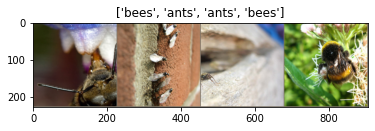

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Set Model Parameters’ .requires_grad attribute**

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later.

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

**Model Training and Validation Code**

The train_model function handles the training and validation of a given model. As input, it takes a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. The is_inception flag is used to accomodate the Inception v3 model, as that architecture uses an auxiliary output and the overall model loss respects both the auxiliary output and the final output, as described here. The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()
    date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

    data_file = open('/content/experiment_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])

    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since_1 = time.time()

        # Each epoch has a training and validation phase
        #data_writer.writerow(['Model','type', 'Dataset', 'Train_loss', 'Train_acc', "val_loss", "Val_acc"])
        rows = [model, 'pytorch','hymenoptera_data','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                   # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print(criterion)
                        loss = criterion(outputs, labels)
                    #outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            rows.append(phase)
            rows.append('Loss: {:.4f}'.format(epoch_loss))
            rows.append('Acc: {:.4f}'.format(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        time_elapsed_1 = time.time() - since_1
        print()
        rows.append(time.time())
        rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
        data_writer.writerow(rows)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

    data_file.close()
    return model, val_acc_history

**Inputs**

Here are all of the parameters to change for the run. We will use the hymenoptera_data dataset which can be downloaded [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip). This dataset contains two classes, bees and ants, and is structured such that we can use the  [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) dataset, rather than writing our own custom dataset. Download the data and set the data_dir input to the root directory of the dataset. The model_name input is the name of the model you wish to use and must be selected from this list:

`[resnet, alexnet, vgg, squeezenet, densenet, inception]`

The other inputs are as follows: num_classes is the number of classes in the dataset, batch_size is the batch size used for training and may be adjusted according to the capability of your machine, num_epochs is the number of training epochs we want to run, and feature_extract is a boolean that defines if we are finetuning or feature extracting. If feature_extract = False, the model is finetuned and all model parameters are updated. If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

In [97]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

**Initialize and Reshape the Networks**

Now to the most interesting part. Here is where we handle the reshaping of each network. Note, this is not an automatic procedure and is unique to each model. Recall, the final layer of a CNN model, which is often times an FC layer, has the same number of nodes as the number of output classes in the dataset. Since all of the models have been pretrained on Imagenet, they all have output layers of size 1000, one node for each class. The goal here is to reshape the last layer to have the same number of inputs as before, AND to have the same number of outputs as the number of classes in the dataset. In the following sections we will discuss how to alter the architecture of each model individually. But first, there is one important detail regarding the difference between finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default of True.

Finally, notice that inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224).

In [98]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [99]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


**Load Data**

Now that we know what the input size must be, we can initialize the data transforms, image datasets, and the dataloaders. Notice, the models were pretrained with the hard-coded normalization values, as described here.

In [100]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
#dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Create the Optimizer**

Now that the model structure is correct, the final step for finetuning and feature extracting is to create an optimizer that only updates the desired parameters. Recall that after loading the pretrained model, but before reshaping, if feature_extract=True we manually set all of the parameter’s .requires_grad attributes to False. Then the reinitialized layer’s parameters have .requires_grad=True by default. So now we know that all parameters that have .requires_grad=True should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.

In [101]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


**Run Training and Validation Step**

Finally, the last step is to setup the loss for the model, then run the training and validation function for the set number of epochs. Notice, depending on the number of epochs this step may take a while on a CPU. Also, the default learning rate is not optimal for all of the models, so to achieve maximum accuracy it would be necessary to tune for each model separately.

In [102]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

RuntimeError: ignored

# Comparison with Model Trained from Scratch

Just for fun, lets see how the model learns if we do not use transfer learning. The performance of finetuning vs. feature extracting depends largely on the dataset but in general both transfer learning methods produce favorable results in terms of training time and overall accuracy versus a model trained from scratch.

In [50]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7009 Acc: 0.4795
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6929 Acc: 0.5943
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6928 Acc: 0.5451
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6923 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6918 Acc: 0.5000
val Loss: 0.6932 Acc: 0.4444

Epoch 5/14
----------
train Loss: 0.6918 Acc: 0.4959
val Loss: 0.6929 Acc: 0.5686

Epoch 6/14
----------
train Loss: 0.6853 Acc: 0.4959
val Loss: 0.6932 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6860 Acc: 0.5369
val Loss: 0.6825 Acc: 0.5425

Epoch 8/14
----------
train Loss: 0.6951 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6930 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6931 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6932 Acc: 0.5164
val Loss: 0.6931 Acc: 0.4575

Epoch 12/14
----------
t

DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


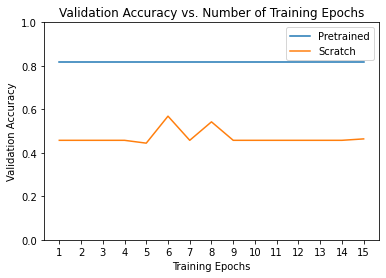

In [51]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.savefig(path+ "Training_validation_{}_{}.pdf".format(model_name,date),dpi=100, format='pdf')
plt.show()

# EXporting the Pytorch model to ONNX then Keras Format

In [52]:
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))
k_model_ft = pytorch_to_keras(model_ft, input_var.cuda(), [(3, 224, 224,)], verbose=True, change_ordering=True)

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (96, 3, 7, 7).
DEBUG:onnx2keras:Found weight features.0.bias with shape (96,).
DEBUG:onnx2keras:Found weight features.3.squeeze.weight with shape (16, 96, 1, 1).
DEBUG:onnx2keras:Found weight features.3.squeeze.bias with shape (16,).
DEBUG:onnx2keras:Found weight features.3.expand1x1.weight with shape (64, 16, 1, 1).
DEBUG:onnx2keras:Found weight features.3.expand1x1.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.expand3x3.weight with shape (64, 16, 3, 3)

graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %features.0.weight : Float(96, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=1, device=cuda:0),
      %features.0.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %features.3.squeeze.weight : Float(16, 96, 1, 1, strides=[96, 1, 1, 1], requires_grad=1, device=cuda:0),
      %features.3.squeeze.bias : Float(16, strides=[1], requires_grad=1, device=cuda:0),
      %features.3.expand1x1.weight : Float(64, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cuda:0),
      %features.3.expand1x1.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %features.3.expand3x3.weight : Float(64, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.3.expand3x3.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %features.4.squeeze.weight : Float(16, 128, 1, 1, strides=[128, 1, 1, 1], requires_grad=1, devi

DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: MaxPool
DEBUG:onnx2keras:node_name: 55
DEBUG:onnx2keras:node_params: {'kernel_shape': [3, 3], 'pads': [0, 0, 1, 1], 'strides': [2, 2], 'change_ordering': True, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 54).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> KerasTensor(type_spec=TensorSpec(shape=(None, 96, 54, 54), dtype=tf.float32, name=None), name='55/MaxPool:0', description="created by layer '55'")
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: 56
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': True, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if 

In [53]:
#batch_size = 4
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/val',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 245 files belonging to 2 classes.
Using 196 files for training.
Found 153 files belonging to 2 classes.
Using 30 files for validation.


In [54]:
i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['train']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_train = inputs
    torch_labels_train = labels
  else:
    torch_images_train = torch.cat([torch_images_train, inputs], 0)
    torch_labels_train = torch.cat([torch_labels_train, labels], 0)
  i_0 += 1
print(torch_images_train.size(), torch_labels_train.size())

i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['val']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_val = inputs
    torch_labels_val = labels
  else:
    torch_images_val = torch.cat([torch_images_val, inputs], 0)
    torch_labels_val = torch.cat([torch_labels_val, labels], 0)
  i_0 += 1
print(torch_images_val.size(), torch_labels_val.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([244, 3, 224, 224]) torch.Size([244])
torch.Size([153, 3, 224, 224]) torch.Size([153])


In [55]:
pred_torch = model_ft(torch_images_train)
pred_torch

RuntimeError: ignored

In [ ]:
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_tf = tf.convert_to_tensor(input_np)
inp_ = tf.convert_to_tensor(input_np)
inp_ = tf.reshape(inp_, (-1,224,224,3))
#print(tf.shape(inp_))
pred = k_model_ft.predict(inp_)
pred

array([[0.09012983, 0.87777585]], dtype=float32)

In [ ]:
x = tf.keras.layers.Input(shape=(None, 180, 180, 3)) # input is 192x192 pixels RGB

#y = tf.keras.layers.Dense(5, activation='softmax')(y)
x

<KerasTensor: shape=(None, None, 180, 180, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
pip install tfkerassurgeon

  Created wheel for tfkerassurgeon: filename=tfkerassurgeon-0.2.1-cp37-none-any.whl size=22040 sha256=8ec981334781ff9603bbe5f1f44f8d7c2ed5de4579dbe544d588a83801021658
  Stored in directory: /root/.cache/pip/wheels/33/41/28/daca963a6834fecf8cd9a3b207288ba325fdf012a7ebd95715
Successfully built tfkerassurgeon


In [ ]:
k_model_ft.layers[0] = x

In [ ]:
#from tensorflow import keras  # or import keras for standalone version
#from tensorflow.keras.layers import Input

#new_input_shape=(None, 180, 180, 3)
# replace input shape of first layer
k_model_ft.layers[0].batch_input_shape = new_input_shape
k_model_ft.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
53 (Conv2D)                     (None, 109, 109, 96) 14208       input_0[0][0]                    
__________________________________________________________________________________________________
54 (Activation)                 (None, 109, 109, 96) 0           53[0][0]                         
__________________________________________________________________________________________________
55_pad (ZeroPadding2D)          (None, 110, 110, 96) 0           54[0][0]                         
____________________________________________________________________________________________

In [56]:
k_model_ft.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [57]:
fit_history_k_model_ft = k_model_ft.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs
)

Epoch 1/15
25/25 [==============================] - 3s 57ms/step - loss: 6.8454 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 2/15
25/25 [==============================] - 1s 41ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 3/15
25/25 [==============================] - 1s 41ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 4/15
25/25 [==============================] - 1s 41ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 5/15
25/25 [==============================] - 1s 40ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 6/15
25/25 [==============================] - 1s 41ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 7/15
25/25 [==============================] - 1s 40ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.3667
Epoch 8/15
25

In [58]:
def export_history_csv(history_):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  data_file = open('/content/tensorflow_exp_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
  for epoch_ in history_.epoch:
    data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
  data_file.close()

def export_history_csv2(history_):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  data_file = open('/content/tensorflow_exp_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', 'time','Elapse_time','date'])
  for epoch_ in history_.epoch:
    data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                           '','',date])
  data_file.close()

In [59]:
export_history_csv(fit_history_k_model_ft)

DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


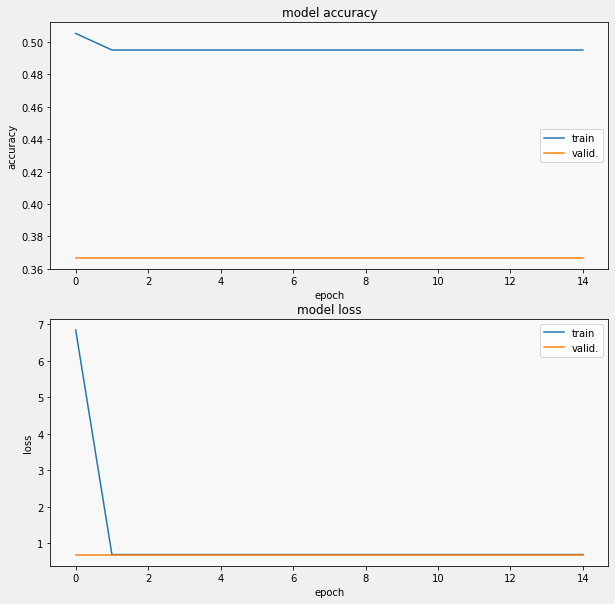

In [60]:
display_training_curves(fit_history_k_model_ft.history['accuracy'], fit_history_k_model_ft.history['val_accuracy'], 'accuracy', 211)
display_training_curves(fit_history_k_model_ft.history['loss'], fit_history_k_model_ft.history['val_loss'], 'loss', 212)

Pytorch to ONNX

In [61]:
# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch_out = model_ft(x.cuda())

# Export the model
torch.onnx.export(model_ft,               # model being run
                  x.cuda(),                         # model input (or a tuple for multiple inputs)
                  "model_ft.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [62]:
import onnx
onnx_model = onnx.load("model_ft.onnx")
onnx.checker.check_model(onnx_model)

In [63]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model_ft.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

In [64]:
# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [65]:
from onnx2keras import onnx_to_keras
k_model_keras = onnx_to_keras(onnx_model, ['input'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (96, 3, 7, 7).
DEBUG:onnx2keras:Found weight features.0.bias with shape (96,).
DEBUG:onnx2keras:Found weight features.3.squeeze.weight with shape (16, 96, 1, 1).
DEBUG:onnx2keras:Found weight features.3.squeeze.bias with shape (16,).
DEBUG:onnx2keras:Found weight features.3.expand1x1.weight with shape (64, 16, 1, 1).
DEBUG:onnx2keras:Found weight features.3.expand1x1.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.expand3x3.weight with shape (64, 16, 3, 3).
DEBUG:onnx2keras:Found weight features.3.expand3x3.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.4.squeeze.weight with shape (16, 128, 1, 1).
DEBUG:onnx2keras:Found weig

In [66]:
tf_images_train = tf.convert_to_tensor(torch_images_train.cpu().numpy())
tf_labels_train = tf.convert_to_tensor(torch_labels_train.cpu().numpy())

tf_images_val = tf.convert_to_tensor(torch_images_val.cpu().numpy())
tf_labels_val = tf.convert_to_tensor(torch_labels_val.cpu().numpy())
tf.shape(tf_images_train)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([244,   3, 224, 224], dtype=int32)>

In [67]:
k_model_keras.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [68]:
fit_history_k_model_keras = k_model_keras.fit(
  tf_images_train,
  tf_labels_train,
  epochs=num_epochs
)

Epoch 1/15
8/8 [==============================] - 2s 82ms/step - loss: 0.9210 - accuracy: 0.5123
Epoch 2/15
8/8 [==============================] - 1s 76ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 3/15
8/8 [==============================] - 1s 75ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 4/15
8/8 [==============================] - 1s 75ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 5/15
8/8 [==============================] - 1s 78ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 6/15
8/8 [==============================] - 1s 78ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 7/15
8/8 [==============================] - 1s 76ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 8/15
8/8 [==============================] - 1s 76ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 9/15
8/8 [==============================] - 1s 76ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 10/15
8/8 [==============================] - 1s 76ms/step - loss: 0.6931 - accuracy: 0.5041
Epoch 11/15
8/8 [============

In [69]:
export_history_csv2(fit_history_k_model_keras)

# convert to onnx-back

In [ ]:
!pip install -U tf2onnx

In [73]:
import tf2onnx

model_proto, external_tensor_storage = tf2onnx.convert.from_keras(k_model_keras,
                input_signature=None, opset=None, custom_ops=None,
                custom_op_handlers=None, custom_rewriter=None,
                inputs_as_nchw=None, extra_opset=None, shape_override=None,
                 target=None, large_model=False, output_path='model_ft_keras.onnx')

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tf2onnx.tfonnx:Using tensorflow=2.5.0, onnx=1.8.1, tf2onnx=1.9.1/8e8c23
INFO:tf2onnx.tfonnx:Using opset <onnx, 9>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
DEBUG:tf2onnx.graph:Making node: Name=Identity, OP=Identity
DEBUG:tf2onnx.graph:Made node: Identity
OP=Identity
Name=Identity
Inputs:
	model_3/output/Reshape:0=Reshape, [-1, -1], 1
Outpus:
	Identity_raw_output___4:0=[-1, -1], 1
DEBUG:tf2onnx.graph:Making node: Name=Identity_graph_outputs_Identity__5, OP=Identity
DEBUG:tf2onnx.graph:Infer shape and dtype for [Identity_graph_outputs_Identity__5]
DEBUG:tf2onnx.graph:Set dtype of [output] to 1
DEBUG:tf2onnx.graph:Set shape of [output] to [-1, -1]
DEBUG:tf2onnx.graph:Made node: Identity_graph_outputs_Identity__5
OP=Identity
Name=Identity_graph_outputs_Identity__5
Inputs:
	Identity_raw_output___4:0=Identity, [-1, -1], 1
Outpus:
	output=[-1, -1], 1
DEBUG:tf2onnx.tfonnx:op name model_3/62/conc

In [74]:
onnx_model_keras = onnx.load("model_ft_keras.onnx")
onnx.checker.check_model(onnx_model_keras)

In [75]:
import onnxruntime

ort_session2 = onnxruntime.InferenceSession("model_ft_keras.onnx")
# compute ONNX Runtime output prediction
ort_inputs2 = {ort_session2.get_inputs()[0].name: to_numpy(x)}
ort_outs2 = ort_session2.run(None, ort_inputs)

In [78]:
np.testing.assert_array_equal(ort_outs2[0], ort_outs[0])

AssertionError: ignored

In [ ]:
!pip install keras2onnx

In [ ]:
import keras2onnx
keras2onnx.convert_keras(k_model_keras, name=None, doc_string='', target_opset=None, channel_first_inputs='model_ft_keras_k2onnx.onnx')
# type: (keras.Model, str, str, int, []) -> onnx.ModelProto


In [88]:
onnx_model_3 = keras2onnx.convert_keras(k_model_keras, k_model_keras.name)   #Call the model conversion function keras2onnx.convert_keras, generate the onnx model, and send it to onnx_model
temp_model_file = 'model_ft_keras_k2onnx_2.onnx'    #Specify the save path of the onnx model and name it yolo.onnx
onnx.save_model(onnx_model_3, temp_model_file)               #Save model

tf executing eager_mode: True
INFO:keras2onnx:tf executing eager_mode: True
tf.keras model eager_mode: False
INFO:keras2onnx:tf.keras model eager_mode: False


AttributeError: ignored

In [79]:
from onnx2keras import onnx_to_keras
k_model_keras_2 = onnx_to_keras(onnx_model_keras, ['input'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight model_3/99/Conv2D/ReadVariableOp:0 with shape (64, 384, 1, 1).
DEBUG:onnx2keras:Found weight model_3/99/BiasAdd/ReadVariableOp:0 with shape (64,).
DEBUG:onnx2keras:Found weight model_3/96/Conv2D/ReadVariableOp:0 with shape (192, 48, 3, 3).
DEBUG:onnx2keras:Found weight model_3/94/Conv2D/ReadVariableOp:0 with shape (192, 48, 1, 1).
DEBUG:onnx2keras:Found weight model_3/94/BiasAdd/ReadVariableOp:0 with shape (192,).
DEBUG:onnx2keras:Found weight model_3/92/Conv2D/ReadVariableOp:0 with shape (48, 384, 1, 1).
DEBUG:onnx2keras:Found weight model_3/92/BiasAdd/ReadVariableOp:0 with shape (48,).
DEBUG:onnx2keras:Found weight model_3/89/Conv2D/ReadVariableOp:0 with shape (192, 48, 3, 3).
DEBU

ValueError: ignored

In [29]:
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of accelerators:  1


In [30]:
import os, sys, math
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 32, there will be 93 batches per training epoch and 21 batch(es) per validation run.


In [31]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  # In eager mode, iterate in the Datset directly.
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  plt.savefig(path+ "Training_loss_{}_keras.pdf".format(date),dpi=100, format='pdf')

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

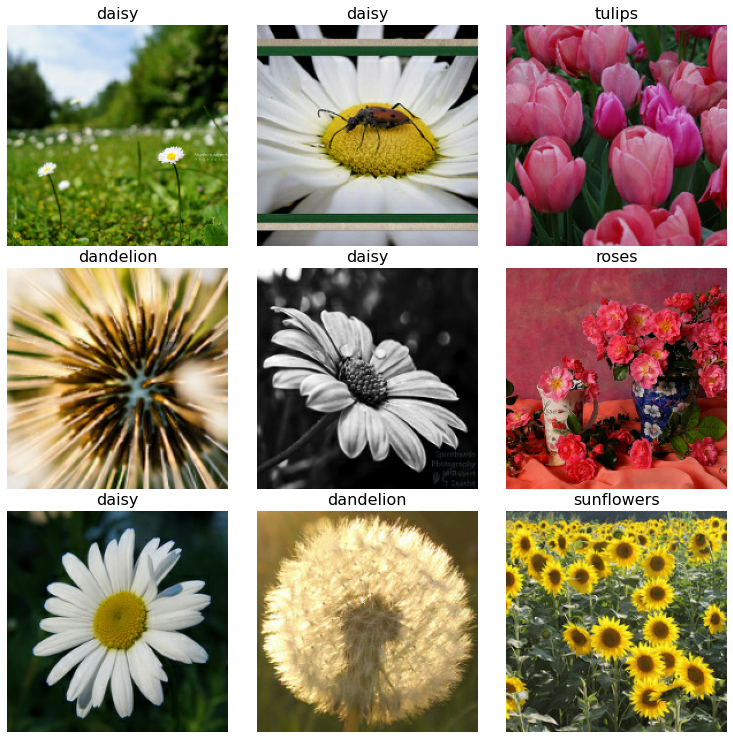

In [ ]:
display_9_images_from_dataset(load_dataset(training_filenames))

In [ ]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2000)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

Tensorflow version 2.5.0


In [ ]:
validation_dataset

<PrefetchDataset shapes: ((None, 192, 192, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [ ]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  bnmomemtum=0.9
  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(5, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
EPOCHS = 10

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
93/93 [==============================] - 685s 7s/step - loss: 1.2078 - accuracy: 0.5252 - val_loss: 1.0816 - val_accuracy: 0.6000
Epoch 2/10
93/93 [==============================] - 653s 7s/step - loss: 1.0204 - accuracy: 0.6085 - val_loss: 1.0436 - val_accuracy: 0.6072
Epoch 3/10
93/93 [==============================] - 656s 7s/step - loss: 0.9198 - accuracy: 0.6465 - val_loss: 0.8618 - val_accuracy: 0.6725
Epoch 4/10
93/93 [==============================] - 656s 7s/step - loss: 0.8956 - accuracy: 0.6542 - val_loss: 0.9163 - val_accuracy: 0.6493
Epoch 5/10
93/93 [==============================] - 656s 7s/step - loss: 0.8557 - accuracy: 0.6737 - val_loss: 0.7667 - val_accuracy: 0.7101
Epoch 6/10
93/93 [==============================] - 654s 7s/step - loss: 0.7782 - accuracy: 0.7093 - val_loss: 0.8236 - val_accuracy: 0.7188
Epoch 7/10
93/93 [==============================] - 653s 7s/step - loss: 0.7592 - accuracy: 0.7157 - val_loss: 0.7352 - val_accuracy: 0.7275
Epoch 8/10
93

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


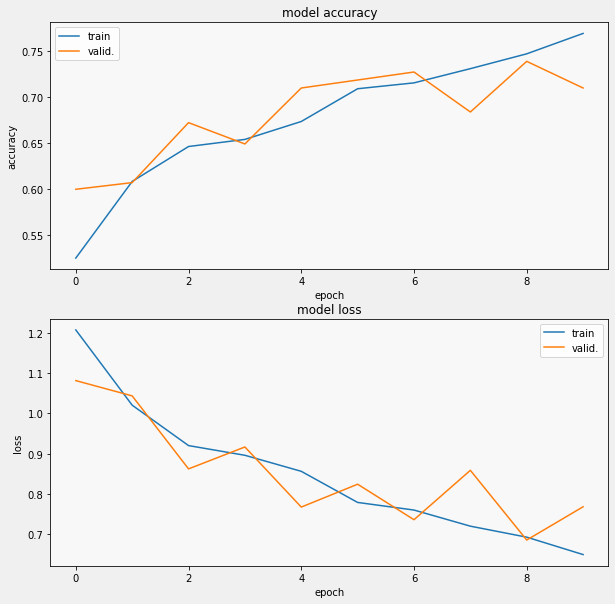

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
export_history_csv(history)
